In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
from math import radians, cos, sin, asin, sqrt, atan2

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def bearing(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])
    _bearing = np.arctan2(np.sin(lon2-lon1)*np.cos(lat2), np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(lon2-lon1))
    return _bearing

def coords_from_geo(lon1, lat1, lon2, lat2):
    # lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])
    distance = haversine(lon1, lat1, lon2, lat2)
    bearing = bearing(lon1, lat1, lon2, lat2)
    return distance*cos(bearing), distance*sin(bearing)

def vector_from_hs(speed, heading):
    return speed*cos(heading), speed*sin(heading)

def heading_norm(heading):
    while heading<0:
        heading = heading+360
    while heading>360:
        heading = heading-360
    return heading

In [3]:
column_names = ['MMSI', 'LAT', 'LON', 'SOG', 'COG', 'Heading', 'VesselType', 'BaseDateTime']
active_columns =['LAT', 'LON', 'SOG', 'Heading']
fig_size=[10,10]

In [4]:
def drop_lt(df, col, min_val):
    return df[df.loc[:, col]>min_val]

def drop_gt(df, col, max_val):
    return df[df.loc[:, col]<max_val]

def drop_eq(df, col, eq_val):
    return df[df.loc[:, col]!=eq_val]

def drop_neq(df, col, eq_val):
    return df[df.loc[:, col]==eq_val]

def drop_cond(df, col, cond_func):
    return df.drop(df[df.loc[:, col].map(cond_func)].index)

In [5]:
def geo2coord(ref_lon, ref_lat, lon, lat, ycoord=False):
    distance = haversine(ref_lon, ref_lat, lon, lat)
    _bearing = bearing(ref_lon, ref_lat, lon, lat)
    if ycoord:
        coord = distance*np.cos(_bearing)
    else:
        coord = distance*np.sin(_bearing)
    return coord

def cs2vectorcoord(speed, heading, ycoord=True):
    speed = speed*1000.0/3600.0 # Convert speed from km/h to m/s
    heading = np.deg2rad(heading) # Convert heading from deg to rad
    if ycoord:
        vectorcoord = speed*np.sin(heading)
    else:
        vectorcoord = speed*np.cos(heading)
    
    return vectorcoord

def angle_between(x1, x2, y1, y2):
    return np.arctan2(y2-y1, x2-x1)


In [6]:
import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x
    
    if window == 'median':
        return medfilt(x, window_len)


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')[int((window_len-1)/2):-int((window_len-1)/2)]
    return y

In [7]:
def smooth_vessel(vessel):
    window_size=21
    window_type='blackman'
    vessel = vessel.copy()
    shifteddata = vessel.shift(periods=1)
    vessel.loc[:, 'PointwiseHeading'] = np.rad2deg(angle_between(shifteddata.Xcoord, vessel.Xcoord, shifteddata.Ycoord, vessel.Ycoord))
    vessel.loc[:, 'PointwiseHeading'] = vessel.loc[:, 'PointwiseHeading'].apply(heading_norm)
    vessel.loc[:, 'PointwiseVectorXcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, 'PointwiseHeading'], False)
    vessel.loc[:, 'PointwiseVectorYcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, 'PointwiseHeading'], True)
    vessel = vessel.dropna()
    window_size=min(window_size, len(vessel)-5)
    if window_size <15:
        return
    try:
        vessel.loc[:, 'SmoothedPointwiseHeading'] = smooth(vessel.loc[:, 'PointwiseHeading'], window_size, window_type)
    except Exception as e:
        print(e)
        print(window_size, len(vessel))
        print(smooth(vessel.loc[:, 'PointwiseHeading'], window_size, window_type))
    vessel.loc[:, 'SmoothedVectorXcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, 'SmoothedPointwiseHeading'], False)
    vessel.loc[:, 'SmoothedVectorYcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, 'SmoothedPointwiseHeading'], True)
    return vessel

In [8]:
count=0
num_chunks=1000
chunk_size=10000
data=pd.DataFrame()
dice_file_loc="AIS_ASCII_by_UTM_Month/2017_v2/AIS_2017_01_Zone18.csv"
file_loc = "/media/dylan/1A46509946507809/AIS_ASCII_by_UTM_Month/2017_v2/AIS_2017_01_Zone18.csv"
mid_lat = 39.248405
mid_lon = -74.81905
pbar = tqdm_notebook(total=num_chunks)
for chunk in pd.read_csv(file_loc, chunksize=chunk_size, usecols=column_names):
    
    # Drop Nans
    chunk=chunk.dropna()

    # Drop stationary points
    chunk = drop_lt(chunk, 'SOG', 0.5)

    # Drop points with nonsensical heading
    chunk = drop_gt(chunk, 'Heading', 500)
    
    # Pick tracks coming from three specific vessel types
    chunk.VesselType = chunk.VesselType.map(int)
    chunk = drop_cond(chunk, 'VesselType', lambda vessel: vessel not in [1004, 1025, 1024])

    # Feature Construction
    chunk.loc[:, 'Xcoord'] = geo2coord(mid_lon, mid_lat, chunk.LON, chunk.LAT, False)
    chunk.loc[:, 'Ycoord'] = geo2coord(mid_lon, mid_lat, chunk.LON, chunk.LAT, True)
    # chunk.loc[:, 'VectorXcoord'] = cs2vectorcoord(chunk.SOG, chunk.Heading, False)
    # chunk.loc[:, 'VectorYcoord'] = cs2vectorcoord(chunk.SOG, chunk.Heading, True)
    
    chunk.loc[:, 'BaseDateTime'] = pd.to_datetime(chunk['BaseDateTime'])
    
    # Append chunk
    data = pd.concat([data, chunk], axis=0, ignore_index=True)
    pbar.update(1)
    pbar.set_description("{:.3f} MB".format(np.sum(data.memory_usage())/1024.0**2))
    pbar.refresh()
    if count>num_chunks:
        break
    count+=1

# Remove short tracks
data = data.groupby("MMSI", sort=False).filter(func=lambda grp : len(grp)>500)

# Sort tracks
data.sort_values(by='BaseDateTime', inplace=True)

# Calculate and smooth pointwise heading
data = data.groupby("MMSI", sort=False).apply(smooth_vessel)
data = data.drop(columns='MMSI').reset_index(0)
data.info()

# groups = data.groupby("MMSI", sort=False)
# groups_dt = groups.apply(lambda grp : ((grp['BaseDateTime']-grp['BaseDateTime'].min())/1000.0).dt.total_seconds())
# data.loc[:, 'DeltaTimeSecs'] = groups_dt.reset_index(0).BaseDateTime    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1312078 entries, 11 to 1344407
Data columns (total 16 columns):
MMSI                        1312078 non-null int64
BaseDateTime                1312078 non-null datetime64[ns]
LAT                         1312078 non-null float64
LON                         1312078 non-null float64
SOG                         1312078 non-null float64
COG                         1312078 non-null float64
Heading                     1312078 non-null float64
VesselType                  1312078 non-null int64
Xcoord                      1312078 non-null float64
Ycoord                      1312078 non-null float64
PointwiseHeading            1312078 non-null float64
PointwiseVectorXcoord       1312078 non-null float64
PointwiseVectorYcoord       1312078 non-null float64
SmoothedPointwiseHeading    1312078 non-null float64
SmoothedVectorXcoord        1312078 non-null float64
SmoothedVectorYcoord        1312078 non-null float64
dtypes: datetime64[ns](1), float64(

In [16]:
%matplotlib
from scipy.signal import medfilt
import matplotlib.dates as mdates

heading_str='PointwiseHeading'
smoothed_str = 'Smoothed{}'.format(heading_str)
subdata_tmp = subdata.sort_values(by='BaseDateTime')
subdata_tmp = subdata_tmp.set_index('BaseDateTime')

subgroups = subdata_tmp.groupby("MMSI", sort=False)
vessel_id = 636091600
vessel = subgroups.get_group(vessel_id)

shifteddata = vessel.shift(periods=1)
vessel.loc[:, 'PointwiseHeading'] = np.rad2deg(angle_between(shifteddata.Xcoord, vessel.Xcoord, shifteddata.Ycoord, vessel.Ycoord))
vessel.loc[:, 'PointwiseHeading'] = vessel.loc[:, 'PointwiseHeading'].apply(heading_norm)
vessel.loc[:, 'PointwiseVectorXcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, heading_str], False)
vessel.loc[:, 'PointwiseVectorYcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, heading_str], True)
vessel = vessel.dropna()
args = args = np.argsort(vessel.index)[0:100]
plt.quiver(vessel["Xcoord"][args], 
           vessel["Ycoord"][args],
           vessel['PointwiseVectorXcoord'][args],
           vessel['PointwiseVectorYcoord'][args],
           angles='xy')

fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax2=fig.add_subplot(212)
colors = ['b', 'r', 'g', 'y', 'p', 'bl']
ax1.plot(vessel.index[args], vessel.loc[:, heading_str][args], label='Raw {}'.format(heading_str))

for window_type in ['median', 'flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
    vessel.loc[:, smoothed_str] = smooth(vessel.loc[:, heading_str], window_size, window_type)
    vessel.loc[:, 'SmoothedVectorXcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, smoothed_str], False)
    vessel.loc[:, 'SmoothedVectorYcoord'] = cs2vectorcoord(vessel.SOG, vessel.loc[:, smoothed_str], True)

    ax1.plot(vessel.index[args], vessel.loc[:, smoothed_str][args], label='Moving {} Filter. Window Size {}'.format(window_type, window_size))
    #plt.figure(figsize=fig_size)
    ax2.quiver(vessel["Xcoord"][args],
               vessel["Ycoord"][args],
               vessel['SmoothedVectorXcoord'][args],
               vessel['SmoothedVectorYcoord'][args],
               angles='xy')
    ax2.set_title('Moving {} Filter. Window Size {}'.format(window_type, window_size))

ax1.legend()

Using matplotlib backend: Qt5Agg
161
161
161
161
161


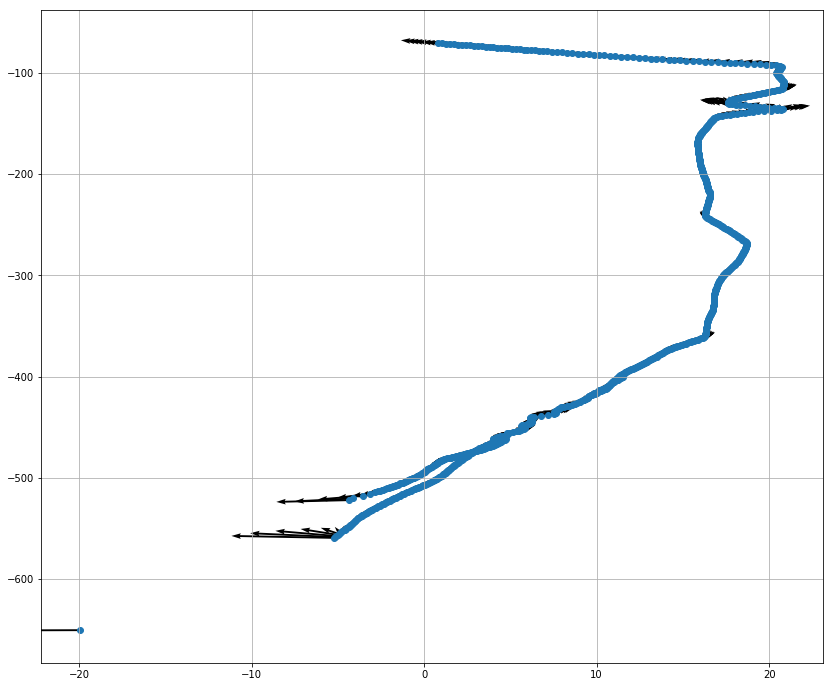

In [42]:
num=1000
fig=plt.figure(figsize=[14, 12])
ax=fig.add_subplot(111)

groups = data.groupby("MMSI", sort=False)
vessel_id = 636091600
vessel = groups.get_group(vessel_id)


ax.quiver(vessel["Xcoord"][0:num], vessel["Ycoord"][0:num],
          vessel['SmoothedVectorXcoord'][0:num], 
          vessel['SmoothedVectorYcoord'][0:num], 
          angles='xy',
          #scale=1,
          scale_units='xy')
plt.grid()
ax.scatter(vessel.Xcoord[0:num], vessel.Ycoord[0:num])

In [43]:
fig_size = [10,10]

In [51]:
import matplotlib.colors as colors
import matplotlib.cm as cm

%matplotlib
# vessel.plot(x="LAT", y="LON")
subgroups = data.groupby("MMSI", sort=False)
vessel_id = 636091600
vessel = subgroups.get_group(vessel_id)

my_norm = colors.Normalize(vessel.SmoothedPointwiseHeading.min(), vessel.SmoothedPointwiseHeading.max())
my_map = cm.ScalarMappable(norm=my_norm, cmap='seismic')

fig=plt.figure(figsize=fig_size)
ax=fig.add_subplot(111)

ax.scatter(vessel["Xcoord"], vessel["Ycoord"], c=my_map.to_rgba(list(vessel.SmoothedPointwiseHeading.values)))
ax.set_title("Sequential plot of reported headings of Vessel ID {}".format(vessel_id))
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Using matplotlib backend: Qt5Agg


In [ ]:
fig_size = [10,10]
# fig=plt.figure(figsize=fig_size)
_ = data.hist(column=["LAT", "LON"], bins=40, figsize=fig_size)

In [ ]:
_ = data.hist(column=["Heading", "COG"], bins=80, figsize=fig_size)

In [ ]:
_ = data.hist(column=["SOG"], bins=100, figsize=fig_size, )

In [ ]:
fig_size = [10,10]
nbins=100

In [257]:
fig = plt.figure(figsize= fig_size)
subdata.plot.scatter("Xcoord", "Ycoord", s=0.05, figsize=fig_size)

In [ ]:
%matplotlib
fig, ax = plt.subplots(figsize=fig_size)
q = ax.quiver(subdata.Xcoord, subdata.Ycoord, subdata.VectorXcoord, subdata.VectorYcoord, scale=15000)

In [ ]:
fig = plt.figure(figsize= fig_size)
data.plot.scatter("Xcoord", "Ycoord", s=0.05, figsize=fig_size)

In [ ]:
nbins=40
fig=plt.figure(figsize=fig_size)

ax1 = fig.add_subplot(211)
data.LAT.plot.hist(ax=ax1, bins=nbins)
data.LAT.plot.kde(ax=ax1, secondary_y=True, title='LAT')

ax2 = fig.add_subplot(212)
data.LON.plot.hist(ax=ax2, bins=nbins)
data.LON.plot.kde(ax=ax2, secondary_y=True, title='LON')

In [40]:
nbins=1000
data.DeltaTimeSecs.plot.hist(bins=nbins, figsize=fig_size)

In [ ]:
new_data.LAT.hist(bins=nbins, figsize=fig_size)

In [71]:
sns.pairplot(data, hue='VesselType', vars=['LON', 'LAT'], plot_kws={"s":20}, diag_kws={"shade" : True}, size=10, diag_kind='kde')

/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


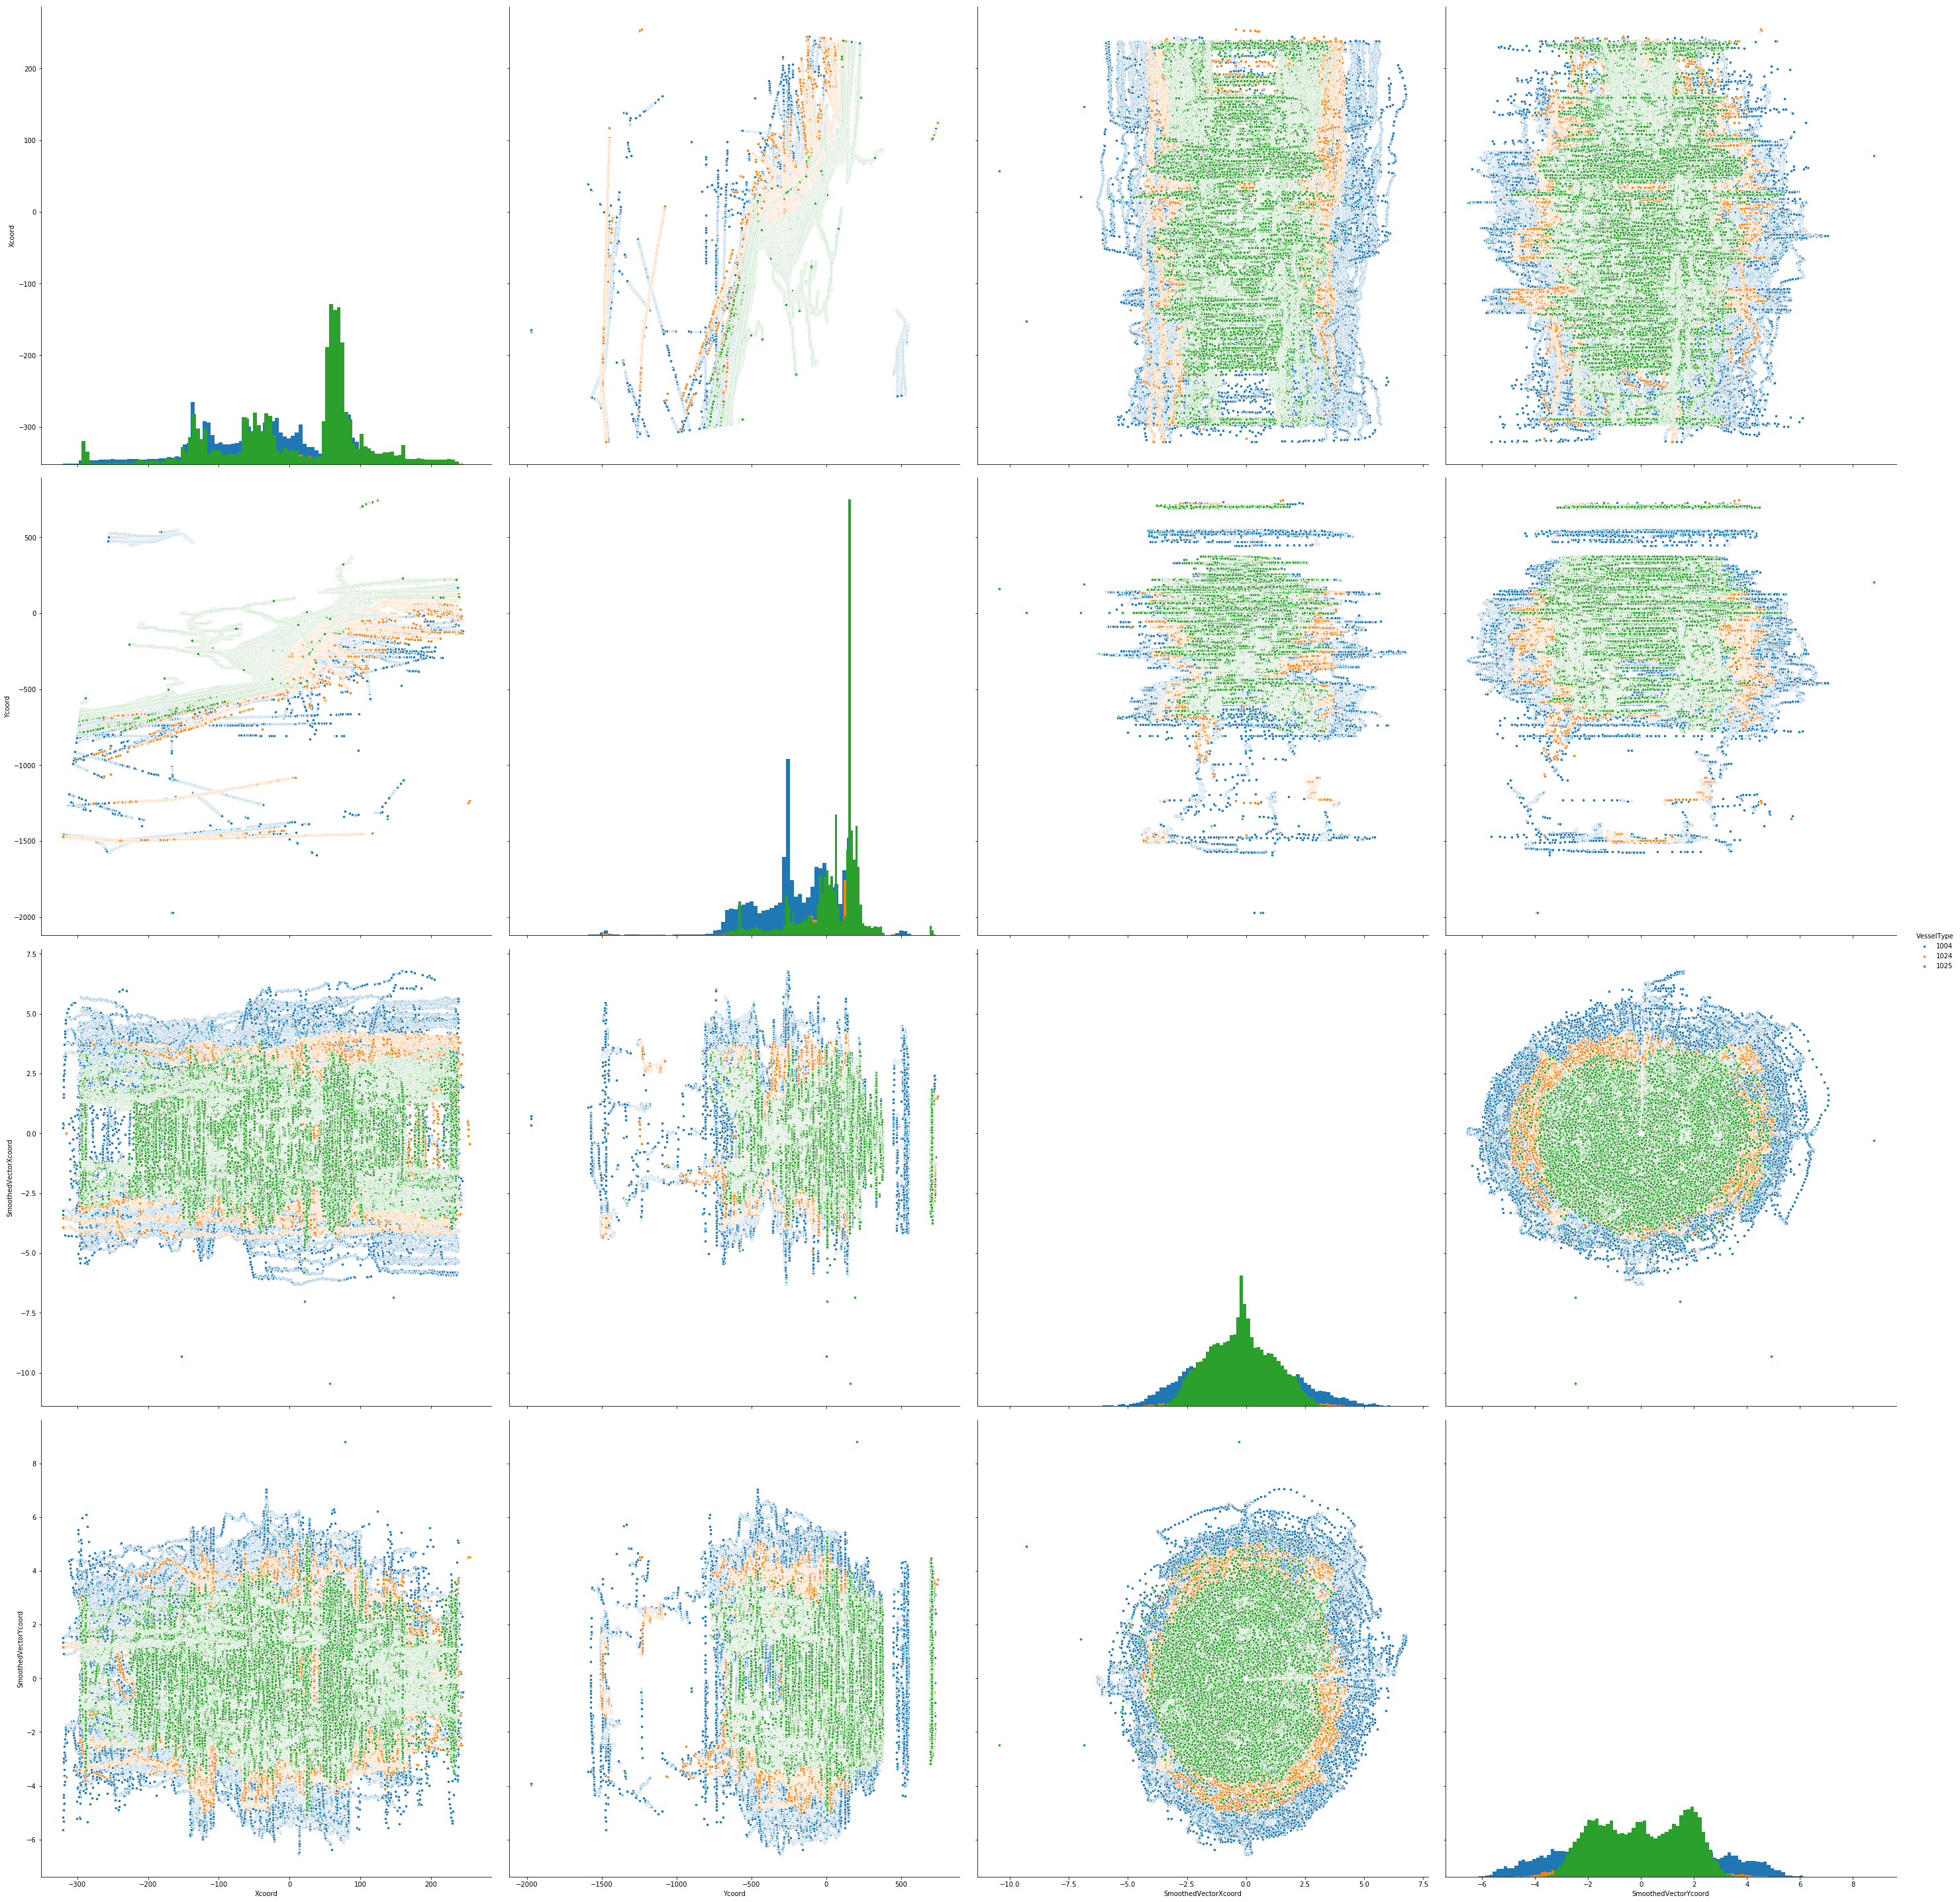

In [123]:
sns.pairplot(data, hue='VesselType', vars=['Xcoord', 'Ycoord', 'SmoothedVectorXcoord', 'SmoothedVectorYcoord'], plot_kws={"s":20}, diag_kws={"bins" : 100}, size=10, diag_kind='hist')

In [33]:
full_ylim=[25,47]
full_xlim=[-78,-72]
ylim=[36,40]
xlim=[-77,-74.5]
groups = data.groupby("VesselType", sort=False)
for vess_type, indxs in groups.groups.items():
    group = data.loc[indxs, :]
    group.plot("LON", "LAT", "scatter", title="Vessel Type {}".format(vess_type), s=0.1)
    #group.plot("LON", "LAT", "scatter", title="Vessel Type {}".format(vess_type), c=group.Heading, cmap='seismic', s=0.1, figsize=fig_size, ylim=full_ylim, xlim=full_xlim)

In [ ]:
full_ylim=[25,47]
full_xlim=[-78,-72]
ylim=[36,40]
xlim=[-77,-74.5]
groups = data.groupby("VesselType", sort=False)
for vess_type, indxs in groups.groups.items():
    group = data.loc[indxs, :]
    group.plot("LON", "LAT", "scatter", c=group.SOG, title="Vessel Type {}".format(vess_type), cmap='seismic', s=0.1, figsize=fig_size, ylim=full_ylim, xlim=full_xlim)

In [ ]:
sns.jointplot(data=data, x='LON', y='LAT', kind='kde', size=14)

# Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score

SEED=0
num_splits=5
n_jobs = 7
kf = StratifiedKFold(num_splits, random_state=SEED)

mask = data.SmoothedVectorYcoord>=0
subdata = data.loc[mask, :]

# Split Data
train_indicies, test_indicies = train_test_split(subdata.index, random_state=SEED, shuffle=True, train_size=0.7, test_size=0.3)
train_indicies, val_indicies = train_test_split(train_indicies, random_state=SEED, shuffle=True, train_size=0.7, test_size=0.3)
train_data = data.loc[train_indicies, :]
val_data = data.loc[val_indicies, :]
test_data = data.loc[test_indicies, :]

X_train = train_data.loc[:, ['Xcoord', 'Ycoord']]
X_val = val_data.loc[:, ['Xcoord', 'Ycoord']]
X_test = test_data.loc[:, ['Xcoord', 'Ycoord']]

y_train = train_data.loc[:, ['SmoothedVectorXcoord', 'SmoothedVectorYcoord']]
y_val = val_data.loc[:, ['SmoothedVectorXcoord', 'SmoothedVectorYcoord']]
y_test = test_data.loc[:, ['SmoothedVectorXcoord', 'SmoothedVectorYcoord']]

print("Train Data shape {}".format(train_data.shape))

Train Data shape (312877, 16)


In [12]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()


X_train_norm = y_train.copy()
X_train_norm.loc[:, :] = x_scaler.fit_transform(X_train)

X_val_norm = y_val.copy()
X_val_norm.loc[:, :] = x_scaler.transform(X_val)

X_test_norm = y_test.copy()
X_test_norm.loc[:, :] = x_scaler.transform(X_test)

y_train_norm = y_train.copy()
y_train_norm.loc[:, :] = y_scaler.fit_transform(y_train)

y_val_norm = y_val.copy()
y_val_norm.loc[:, :] = y_scaler.transform(y_val)

y_test_norm = y_test.copy()
y_test_norm.loc[:, :] = y_scaler.transform(y_test)



In [54]:
def holdout_score(reg, X_train, y_train, X_val, y_val):
    reg.fit(X_train, y_train)
    train_pred = reg.predict(X_train)
    val_pred = reg.predict(X_val)
    train_mse = mean_squared_error(y_train, train_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)

    return train_mse, val_mse, train_r2, val_r2

## Baselines

In [55]:
from sklearn.dummy import DummyRegressor

dummyreg = DummyRegressor("mean")
results = holdout_score(dummyreg, X_train, y_train, X_val, y_val)
print('train mse {:.3e} val mse {:.3e}\ntrain R^2 {:.5e} val R^2 {:.5e}'.format(*results))

train mse 1.303e+00 val mse 1.294e+00
train R^2 -2.83107e-15 val R^2 -2.37922e-05


In [57]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
results = holdout_score(linreg, X_train, y_train, X_val, y_val)
print('train mse {:.3e} val mse {:.3e}\ntrain R^2 {:.5e} val R^2 {:.5e}'.format(*results))

train mse 1.159e+00 val mse 1.150e+00
train R^2 1.11250e-01 val R^2 1.11104e-01


In [25]:
class CosineAnnealingWithWarmRestarts(object):
    """Cosine annealing scheduler, implemented as in https://arxiv.org/pdf/1608.03983.pdf"""

    def __init__(self,
                 min_learning_rate=0.00001,
                 max_learning_rate=0.01,
                 total_iters_per_period=100,
                 max_learning_rate_discount_factor=0.9,
                 period_iteration_expansion_factor=1):
        """
        Instantiates a new cosine annealing with warm restarts learning rate scheduler
        :param min_learning_rate: The minimum learning rate the scheduler can assign
        :param max_learning_rate: The maximum learning rate the scheduler can assign
        :param total_epochs_per_period: The number of epochs in a period
        :param max_learning_rate_discount_factor: The rate of discount for the maximum learning rate after each restart i.e. how many times smaller the max learning rate will be after a restart compared to the previous one
        :param period_iteration_expansion_factor: The rate of expansion of the period epochs. e.g. if it's set to 1 then all periods have the same number of epochs, if it's larger than 1 then each subsequent period will have more epochs and vice versa.
        """
        self.min_learning_rate = min_learning_rate
        self.max_learning_rate = max_learning_rate
        self.total_epochs_per_period = total_iters_per_period

        self.max_learning_rate_discount_factor = max_learning_rate_discount_factor
        self.period_iteration_expansion_factor = period_iteration_expansion_factor


    def update_learning_rule(self, epoch_number, learning_rate):
        """Update the hyperparameters of the learning rule.

        Run at the beginning of each epoch.

        Args:
            learning_rule: Learning rule object being used in training run,
                any scheduled hyperparameters to be altered should be
                attributes of this object.
            epoch_number: Integer index of training epoch about to be run.
        """
        print("epoch")
        if self.period_iteration_expansion_factor != 1:
            n = np.floor(np.log(1+(self.period_iteration_expansion_factor-1)*(epoch_number/self.total_epochs_per_period))/np.log(self.period_iteration_expansion_factor))

            total_epochs_per_period = ((1-self.period_iteration_expansion_factor**(n+1))/(1-self.period_iteration_expansion_factor))*self.total_epochs_per_period

        else:
            n = np.floor(epoch_number/self.total_epochs_per_period)
            total_epochs_per_period = self.total_epochs_per_period*(self.period_iteration_expansion_factor)**n
        
        discount = self.max_learning_rate_discount_factor**n
        epoch_number = epoch_number%total_epochs_per_period
        
        cos_val = np.cos(np.pi*(epoch_number/total_epochs_per_period))
        lr_diff = discount*self.max_learning_rate - self.min_learning_rate
        learning_rate = self.min_learning_rate + 0.5*lr_diff*(1+cos_val)

        return learning_rate




In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer
from keras.optimizers import Adam, SGD
from keras.regularizers import l2

from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from tensorflow import set_random_seed, Session

from sklearn.model_selection import ParameterGrid
set_random_seed(SEED)


def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

rootgraphdir='../graphlogs/'
rootmodeldir='../models/'

C = 1e-3
learning_rate = 0.0001
sess = Session()
K.set_session(sess)

def create_model(layers:list, optimizer:str):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=np.size(X_train, 1), activation='relu'))
    for num_neurons in layers[1::]:
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(2, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = optimizer, metrics = [coeff_determination])
    return model



Using TensorFlow backend.


In [23]:
def nn_grid_search(model_func, params_grid):
    for params in params_grid:
        nnclf = create_model(**params)
        nn_holdout_score(nnclf, X_train, y_train, X_val, y_val, num_epochs, batch_size)

def nn_holdout_score(nnreg, trainX, trainY, valX, valY, num_epochs, batch_size, calbacks):
    history = nnreg.fit(trainX,
                        trainY,
                        validation_data=(valX, valY),
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        verbose=1
                       )
    train_pred = nnreg.predict(trainX)
    val_pred = nnreg.predict(valX)
    
    train_r2 = r2_score(trainY, train_pred)
    val_r2 = r2_score(valY, val_pred)
    
    # plt.plot(history.history['coeff_determination'], label='train')
    # plt.plot(history.history['val_coeff_determination'], label='val')
    # plt.legend()
    # plt.show()
    return train_r2, val_r2, history

def nn_cross_val_score(model_func, X_train, y_train, num_epochs, batch_size):
    val_accs=[]
    for train_split_index, val_index in kf.split(X_train, y_train):
        nnclf=model_func()
        trainX = X_train.iloc[train_split_index, :]
        valX = X_train.iloc[val_index, :]
        trainY = y_train[train_split_index]
        valY = y_train[val_index]
        history = nnclf.fit(trainX, trainY, validation_data=(valX, valY), epochs=num_epochs, batch_size=batch_size)
        _, train_acc = nnclf.evaluate(trainX, trainY, verbose=0)
        _, val_acc = nnclf.evaluate(valX, valY, verbose=0)
        val_accs.append(val_acc)
        print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
        plt.plot(history.history['acc'], label='train')
        plt.plot(history.history['val_acc'], label='test')
        plt.legend()
        plt.show()
    return val_accs

In [211]:
from functools import reduce

num_epochs=1000
total_iters_per_period=500
max_learning_rate_discount_factor=0.99
batch_size=256
layers=[128, 64]
optimizer='adam'
modeldir = "ffnn_{}".format(batch_size)+'_'
modeldir += reduce(lambda x,y : x+ y, ['{}_'.format(layer) for layer in layers]) + optimizer
tensorboardcb = TensorBoard(log_dir=rootgraphdir+modeldir, histogram_freq=0,  
                  write_graph=True, write_images=True)
modelcheckptcb = ModelCheckpoint(rootmodeldir+modeldir+'.hd5', monitor='val_loss', save_best_only=True, verbose=0)
scheduler = CosineAnnealingWithWarmRestarts(max_learning_rate_discount_factor=max_learning_rate_discount_factor, total_iters_per_period=total_iters_per_period)
schedulercb = LearningRateScheduler(schedule=scheduler.update_learning_rule)

callbacks=[tensorboardcb, modelcheckptcb, schedulercb]
nnclf = create_model(layers, optimizer)
results = nn_holdout_score(nnclf, X_train, y_train, X_val, y_val, num_epochs, batch_size, callbacks)
print("Train r2 {:.3f} Val r2 {:.3f}".format(results[0], results[1]))


Train on 162397 samples, validate on 69599 samples
Epoch 1/1000
epoch
162397/162397 [==============================] - 3s 19us/step - loss: 10.7486 - coeff_determination: -7.0747 - val_loss: 1.1043 - val_coeff_determination: 0.1994
Epoch 2/1000
epoch
162397/162397 [==============================] - 2s 11us/step - loss: 1.0595 - coeff_determination: 0.2376 - val_loss: 0.9353 - val_coeff_determination: 0.3222
Epoch 3/1000
epoch
162397/162397 [==============================] - 2s 10us/step - loss: 0.9781 - coeff_determination: 0.2968 - val_loss: 1.0003 - val_coeff_determination: 0.2752
Epoch 4/1000
epoch
162397/162397 [==============================] - 2s 9us/step - loss: 0.9591 - coeff_determination: 0.3106 - val_loss: 0.9573 - val_coeff_determination: 0.3058
Epoch 5/1000
epoch
162397/162397 [==============================] - 2s 10us/step - loss: 0.9478 - coeff_determination: 0.3185 - val_loss: 0.9219 - val_coeff_determination: 0.3317
Epoch 6/1000
epoch
162397/162397 [===================

Epoch 92/1000
epoch
162397/162397 [==============================] - 2s 9us/step - loss: 0.8523 - coeff_determination: 0.3872 - val_loss: 0.8560 - val_coeff_determination: 0.3797
Epoch 93/1000
epoch
162397/162397 [==============================] - 2s 9us/step - loss: 0.8515 - coeff_determination: 0.3878 - val_loss: 0.8399 - val_coeff_determination: 0.3912
Epoch 94/1000
epoch
162397/162397 [==============================] - 2s 9us/step - loss: 0.8526 - coeff_determination: 0.3869 - val_loss: 0.8386 - val_coeff_determination: 0.3920
Epoch 95/1000
epoch
162397/162397 [==============================] - 2s 10us/step - loss: 0.8500 - coeff_determination: 0.3890 - val_loss: 0.8674 - val_coeff_determination: 0.3708
Epoch 96/1000
epoch
162397/162397 [==============================] - 2s 10us/step - loss: 0.8522 - coeff_determination: 0.3877 - val_loss: 0.8399 - val_coeff_determination: 0.3909
Epoch 97/1000
epoch
162397/162397 [==============================] - 2s 10us/step - loss: 0.8527 - coef

162397/162397 [==============================] - 1s 9us/step - loss: 0.8178 - coeff_determination: 0.4119 - val_loss: 0.8128 - val_coeff_determination: 0.4105
Epoch 183/1000
epoch
162397/162397 [==============================] - 1s 9us/step - loss: 0.8176 - coeff_determination: 0.4120 - val_loss: 0.8137 - val_coeff_determination: 0.4100
Epoch 184/1000
epoch
162397/162397 [==============================] - 1s 9us/step - loss: 0.8175 - coeff_determination: 0.4123 - val_loss: 0.8129 - val_coeff_determination: 0.4105
Epoch 185/1000
epoch
162397/162397 [==============================] - 1s 9us/step - loss: 0.8173 - coeff_determination: 0.4125 - val_loss: 0.8125 - val_coeff_determination: 0.4108
Epoch 186/1000
epoch
162397/162397 [==============================] - 1s 9us/step - loss: 0.8171 - coeff_determination: 0.4127 - val_loss: 0.8133 - val_coeff_determination: 0.4102
Epoch 187/1000
epoch
162397/162397 [==============================] - 2s 10us/step - loss: 0.8168 - coeff_determination: 

162397/162397 [==============================] - 2s 10us/step - loss: 0.8480 - coeff_determination: 0.3905 - val_loss: 0.8604 - val_coeff_determination: 0.3755
Epoch 273/1000
epoch
162397/162397 [==============================] - 2s 9us/step - loss: 0.8466 - coeff_determination: 0.3913 - val_loss: 0.8285 - val_coeff_determination: 0.3992
Epoch 274/1000
epoch
162397/162397 [==============================] - 1s 9us/step - loss: 0.8471 - coeff_determination: 0.3909 - val_loss: 0.8377 - val_coeff_determination: 0.3922
Epoch 275/1000
epoch
162397/162397 [==============================] - 2s 9us/step - loss: 0.8469 - coeff_determination: 0.3913 - val_loss: 0.8311 - val_coeff_determination: 0.3974
Epoch 276/1000
epoch
162397/162397 [==============================] - 2s 10us/step - loss: 0.8440 - coeff_determination: 0.3932 - val_loss: 0.8395 - val_coeff_determination: 0.3912
Epoch 277/1000
epoch
162397/162397 [==============================] - 2s 11us/step - loss: 0.8453 - coeff_determination

162397/162397 [==============================] - 2s 10us/step - loss: 0.8024 - coeff_determination: 0.4232 - val_loss: 0.7942 - val_coeff_determination: 0.4239
Epoch 363/1000
epoch
162397/162397 [==============================] - 1s 9us/step - loss: 0.8017 - coeff_determination: 0.4238 - val_loss: 0.7932 - val_coeff_determination: 0.4247
Epoch 364/1000
epoch
162397/162397 [==============================] - 1s 9us/step - loss: 0.8013 - coeff_determination: 0.4239 - val_loss: 0.7930 - val_coeff_determination: 0.4249
Epoch 365/1000
epoch
162397/162397 [==============================] - 2s 10us/step - loss: 0.8013 - coeff_determination: 0.4240 - val_loss: 0.7932 - val_coeff_determination: 0.4247
Epoch 366/1000
epoch
162397/162397 [==============================] - 2s 11us/step - loss: 0.8006 - coeff_determination: 0.4244 - val_loss: 0.7961 - val_coeff_determination: 0.4227
Epoch 367/1000
epoch
162397/162397 [==============================] - 2s 12us/step - loss: 0.8012 - coeff_determinatio

162397/162397 [==============================] - 1s 9us/step - loss: 0.8344 - coeff_determination: 0.4002 - val_loss: 0.8372 - val_coeff_determination: 0.3932
Epoch 453/1000
epoch
162397/162397 [==============================] - 1s 9us/step - loss: 0.8385 - coeff_determination: 0.3971 - val_loss: 0.8281 - val_coeff_determination: 0.3994
Epoch 454/1000
epoch
162397/162397 [==============================] - 2s 10us/step - loss: 0.8389 - coeff_determination: 0.3967 - val_loss: 0.8474 - val_coeff_determination: 0.3850
Epoch 455/1000
epoch
162397/162397 [==============================] - 1s 9us/step - loss: 0.8381 - coeff_determination: 0.3976 - val_loss: 0.8315 - val_coeff_determination: 0.3973
Epoch 456/1000
epoch
162397/162397 [==============================] - 1s 9us/step - loss: 0.8363 - coeff_determination: 0.3988 - val_loss: 0.8132 - val_coeff_determination: 0.4103
Epoch 457/1000
epoch
162397/162397 [==============================] - 1s 9us/step - loss: 0.8393 - coeff_determination: 

KeyboardInterrupt: 

In [206]:
for layer in nnclf.weights:
    w = layer.value()
    plt.figure()
    plt.hist(w.eval(session=sess).flatten(), bins=50)

In [166]:
vessel = train_data.groupby("MMSI").get_group(338447000)

In [148]:
sns.pairplot(vessel, hue='VesselType', vars=['Xcoord', 'Ycoord', 'SmoothedVectorXcoord', 'SmoothedVectorYcoord'], plot_kws={"s":20}, diag_kws={"bins" : 100}, size=10, diag_kind='hist')

/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


In [34]:
%matplotlib
from mpl_toolkits.mplot3d import Axes3D

def plot_model_scatter(vessel, nnclf, xscaler, yscaler):
    prediction = yscaler.transform(nnclf.predict(xscaler.transform(vessel.loc[:, ['Xcoord', 'Ycoord']])))
    fig = plt.figure()
    ax1 = fig.add_subplot(211, projection='3d')
    ax1.scatter(vessel.Xcoord, vessel.Ycoord, vessel.SmoothedVectorXcoord, 'b', label='True VectorXcoord')
    ax1.scatter(vessel.Xcoord, vessel.Ycoord, prediction[:,0], 'r', label='Predicted VectorXcoord')
    ax1.set_xlabel("Xcoord")
    ax1.set_ylabel("Ycoord")
    ax1.set_zlabel("SmoothedVectorXcoord")



    ax2 = fig.add_subplot(212, projection='3d')
    ax2.scatter(vessel.Xcoord, vessel.Ycoord, vessel.SmoothedVectorYcoord, 'b', label='True VectorXcoord')
    ax2.scatter(vessel.Xcoord, vessel.Ycoord, prediction[:,1], 'r', label='Predicted VectorXcoord')
    ax2.set_xlabel("Xcoord")
    ax2.set_ylabel("Ycoord")
    ax2.set_zlabel("SmoothedVectorYcoord")

    plt.legend()

Using matplotlib backend: Qt5Agg


In [28]:
%matplotlib
def plot_model_quiver(vessel, nnclf, xscaler, yscaler):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax1.quiver(vessel["Xcoord"], 
               vessel["Ycoord"],
               vessel['SmoothedVectorXcoord'], 
               vessel['SmoothedVectorYcoord'], 
               angles='xy',
               scale=2,
               scale_units='xy')
    ax1.scatter(vessel.Xcoord, vessel.Ycoord, s=0.1)
    ax1.set_xlabel("Xcoord")
    ax1.set_ylabel("Ycoord")
    ax1.grid()
    ax1.set_title("Truth")


    ax2 = fig.add_subplot(212)
    pred = yscaler.transform(nnclf.predict(xscaler.transform(vessel.loc[:, ['Xcoord', 'Ycoord']])))
    ax2.quiver(vessel.Xcoord,
               vessel.Ycoord,
               pred[:, 0],
               pred[:, 1],
               angles='xy',
               scale=2,
               scale_units='xy')
    ax2.scatter(vessel.Xcoord, vessel.Ycoord, s=0.1)
    ax2.set_xlabel("Xcoord")
    ax2.set_ylabel("Ycoord")
    ax2.grid()
    ax2.set_title("Prediction")
# plt.legend()

Using matplotlib backend: Qt5Agg


In [209]:
vessel = train_data.groupby("MMSI").get_group(636091600)
plot_model_scatter(vessel, nnclf)
plot_model_quiver(vessel, nnclf)

## Recurrent Neural Network

## Preprocessing

#### Construct sequences

In [81]:
def construct_vessel_timeseries_data(vessel, seq_length, periods):
    X = [vessel.loc[vessel.index[i*periods:i*periods+seq_length], ['Xcoord', 'Ycoord']].values for i in range(int((len(vessel)-seq_length)/periods))]
    y = [vessel.loc[vessel.index[i*periods+seq_length-1], ['SmoothedVectorXcoord', 'SmoothedVectorYcoord']].values for i in range(int((len(vessel)-seq_length)/periods))]
    return X, y

def construct_timeseries_data(data, seq_length, periods):
    X=[]
    y=[]
    for mmsi, vessel in tqdm_notebook(data.groupby("MMSI")):
        vesselX, vesselY = construct_vessel_timeseries_data(vessel, seq_length, periods)
        X += vesselX
        y += vesselY
    return np.reshape(X, (-1, seq_length, 2)), np.reshape(y, (-1, 2))

In [83]:
seq_length=10
period=2
X_rec, y_rec = construct_timeseries_data(data, seq_length, period)

#### Train-Val-Test Split

In [18]:
train_indicies_rec, test_indicies_rec = train_test_split(range(np.size(X_rec,0)), random_state=SEED, shuffle=True, train_size=0.7, test_size=0.3)
train_indicies_rec, val_indicies_rec = train_test_split(train_indicies_rec, random_state=SEED, shuffle=True, train_size=0.7, test_size=0.3)

X_train_rec = X_rec[train_indicies_rec, :, :]
X_val_rec = X_rec[val_indicies_rec, :, :]
X_test_rec = X_rec[test_indicies_rec, :, :]

y_train_rec = y_rec[train_indicies_rec, :]
y_val_rec = y_rec[val_indicies_rec, :]
y_test_rec = y_rec[test_indicies_rec, :]

#### Normalizing

In [19]:
X_scaler_rec = StandardScaler()
y_scaler_rec = StandardScaler()

X_train_norm_rec = X_scaler_rec.fit_transform(X_train_rec.reshape((-1, 2))).reshape(-1, 2, seq_length)
X_val_norm_rec = X_scaler_rec.transform(X_val_rec.reshape((-1, 2))).reshape(-1, 2, seq_length)
X_test_norm_rec = X_scaler_rec.transform(X_test_rec.reshape((-1, 2))).reshape(-1, 2, seq_length)

y_scaler_rec = StandardScaler()
y_train_norm_rec = y_scaler_rec.fit_transform(y_train_rec.reshape((-1, 2))).reshape(-1, 2)
y_val_norm_rec = y_scaler_rec.transform(y_val_rec.reshape((-1, 2))).reshape(-1, 2)
y_test_norm_rec = y_scaler_rec.transform(y_test_rec.reshape((-1, 2))).reshape(-1, 2)


/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dylan/miniconda3/envs/mlp/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [20]:
def create_rnn_model(seq_length:int, num_lstm_units:int, optimizer:str):
    model = Sequential()
    model.add(InputLayer((np.size(X_train, 1), seq_length)))
    model.add(LSTM(num_lstm_units))
    model.add(Dense( 2, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = optimizer, metrics = [coeff_determination])
    return model


#### Perform fit

In [26]:
# fit params
num_epochs=500
batch_size=64


# learning rate scheduler params
total_iters_per_period=250
max_learning_rate_discount_factor=0.99

# model params
num_lstm_units=128
optimizer='adam'

modeldir = 'rnn_{}_{}_{}'.format(batch_size, num_lstm_units, optimizer)

# Set up callbacks
def get_callbacks(tensorboardfp, modelcheckptfp, **schedulerkwparams):
    tensorboardcb = TensorBoard(log_dir=rootgraphdir+modeldir, histogram_freq=0,  
                      write_graph=True, write_images=True)
    modelcheckptcb = ModelCheckpoint(rootmodeldir+modeldir+'.hd5', monitor='val_loss', save_best_only=True, verbose=0)
    scheduler = CosineAnnealingWithWarmRestarts(**schedulerkwparams)
    schedulercb = LearningRateScheduler(schedule=scheduler.update_learning_rule)
    return [tensorboardcb, modelcheckptcb, schedulercb]

callbacks = get_callbacks(rootgraphdir+modeldir,
                          rootmodeldir+modeldir+'.hd5',
                          max_learning_rate_discount_factor=max_learning_rate_discount_factor,
                          total_iters_per_period=total_iters_per_period)

rnnreg = create_rnn_model(seq_length, num_lstm_units, optimizer)
rnnreg.summary()
results = nn_holdout_score(rnnreg, X_train_norm_rec, y_train_norm_rec, X_val_norm_rec, y_val_norm_rec, num_epochs, batch_size, callbacks)

print("Train r2 {:.3f} Val r2 {:.3f}".format(results[0], results[1]))


Train on 320103 samples, validate on 137188 samples
Epoch 1/500
epoch
320103/320103 [==============================] - 23s 71us/step - loss: 0.9414 - coeff_determination: 0.0505 - val_loss: 0.7322 - val_coeff_determination: 0.2600
Epoch 2/500
epoch
320103/320103 [==============================] - 22s 68us/step - loss: 0.6223 - coeff_determination: 0.3701 - val_loss: 0.5088 - val_coeff_determination: 0.4844
Epoch 3/500
epoch
320103/320103 [==============================] - 23s 72us/step - loss: 0.4250 - coeff_determination: 0.5689 - val_loss: 0.3355 - val_coeff_determination: 0.6596
Epoch 4/500
epoch
320103/320103 [==============================] - 23s 71us/step - loss: 0.2923 - coeff_determination: 0.7032 - val_loss: 0.2183 - val_coeff_determination: 0.7779
Epoch 5/500
epoch
320103/320103 [==============================] - 22s 69us/step - loss: 0.2430 - coeff_determination: 0.7528 - val_loss: 0.2083 - val_coeff_determination: 0.7882
Epoch 6/500
epoch
320103/320103 [====================

KeyboardInterrupt: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               71168     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 71,426
Trainable params: 71,426
Non-trainable params: 0
_________________________________________________________________


In [75]:
vessel = train_data.groupby("MMSI").get_group(636091600)
plot_rnn_model_scatter(vessel, rnnreg, X_scaler_rec, y_scaler_rec, seq_length, period)
#plot_model_quiver(vessel, rnnreg, X_scaler_rec, y_scaler_rec)

112/112 [==============================] - 0s 27us/step
[17.383199419294083, -14.453121185302734]
(112,) (112,)
[[-1.36612934  1.35225819]
 [ 0.27795723  2.1063735 ]
 [ 1.3343609   1.70939515]
 [-1.35665778  1.35867229]
 [ 0.09995358  2.12150182]
 [-1.36388849  1.43444121]
 [ 0.15714194  2.07246669]
 [ 0.23701431  1.89892915]
 [-0.66524823  0.49963055]
 [ 0.11756078  2.12162679]
 [-1.26430077  1.37056185]
 [ 0.24583069  2.1812988 ]
 [-1.3770934   1.37746833]
 [ 0.21693109  2.1575186 ]
 [ 0.26886751  2.1805034 ]
 [ 0.3835585   2.14967275]
 [ 0.09804434  2.10920322]
 [-0.84899336  1.02969598]
 [-0.94414815  0.901985  ]
 [-1.17491401  0.70737767]
 [ 0.63091837  2.26055221]
 [ 0.21431574  2.04702082]
 [ 0.10548463  2.10927134]
 [ 0.38512759  1.85342665]
 [ 0.97161003  1.35740671]
 [ 0.76158491  1.83628818]
 [ 0.46553059  2.25419614]
 [ 0.38072347  2.22383433]
 [-1.55150769  1.22885171]
 [ 0.40050328  2.24710906]] [[ 2.9455655e+00  3.0557425e+00]
 [ 1.0611571e+00  1.2319564e+00]
 [-2.351966

In [74]:
%matplotlib
from mpl_toolkits.mplot3d import Axes3D

def plot_rnn_model_scatter(vessel, rnnreg, xscaler, yscaler, seq_length, period):
    X,y = construct_vessel_timeseries_data(vessel, seq_length, period)
    prediction = (rnnreg.predict(xscaler.transform(np.reshape(X, (-1, 2))).reshape((-1, 2, seq_length))))
    print(rnnreg.evaluate(xscaler.transform(np.reshape(X, (-1, 2))).reshape((-1, 2, seq_length)), yscaler.transform(y)))
    print(prediction[:, 0].shape, np.shape([x[-1, 0] for x in X]))
    transvec = yscaler.transform(vessel.loc[:, ["SmoothedVectorXcoord", "SmoothedVectorYcoord"]])
    print(transvec[0:30, :], prediction[0:30, :])
    fig = plt.figure()
    ax1 = fig.add_subplot(211, projection='3d')
    ax1.scatter(vessel.Xcoord, vessel.Ycoord, transvec[:, 0], 'b', label='True VectorXcoord')
    ax1.scatter([x[-1, 0] for x in X], [x[-1, 1] for x in X], prediction[:,0], 'r', label='Predicted VectorXcoord')
    ax1.set_xlabel("Xcoord")
    ax1.set_ylabel("Ycoord")
    ax1.set_zlabel("SmoothedVectorXcoord")



    ax2 = fig.add_subplot(212, projection='3d')
    ax2.scatter(vessel.Xcoord, vessel.Ycoord, vessel.SmoothedVectorYcoord, 'b', label='True VectorXcoord')
    ax2.scatter([x[-1, 0] for x in X], [x[-1, 1] for x in X], prediction[:,1], 'r', label='Predicted VectorXcoord')
    ax2.set_xlabel("Xcoord")
    ax2.set_ylabel("Ycoord")
    ax2.set_zlabel("SmoothedVectorYcoord")

    plt.legend()

Using matplotlib backend: Qt5Agg


In [62]:
rnnreg.evaluate(X_train_norm_rec, y_train_norm_rec)

320103/320103 [==============================] - 7s 23us/step


[0.11182670431982483, 0.8843359100279125]

In [80]:
X_rec[10, :,:]


array([[ 5.47351800e+00, -2.52704763e+02,  4.99727964e+00,
        -2.52752881e+02,  3.00783614e+00, -2.52890625e+02,
         2.51468854e+00, -2.52934157e+02,  2.01975808e+00,
        -2.52975436e+02],
       [ 1.51771337e+00, -2.53013351e+02,  1.02899275e+00,
        -2.53049010e+02,  5.36713396e-01, -2.53082415e+02,
        -1.41288213e-01, -2.53145813e+02, -7.73088616e-01,
        -2.53169128e+02]])